# Кластеризация и классификация парадигм
## Используемые датасеты: 
- _gsd_train_data_
- _gsd_dev_data_
- _taiga_train_data_
- _taiga_dev_data_

## Используемые методы кластеризации:
- _K-means_
- _DBSCAN_
- _Agglomerative Clustering_
- _Random Forest_
- _Naive Bayes_

### 0. Необходимые импорты

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import pandas as pd
import numpy as np
import time
import csv

### Путь к файлу с датасетом и путь сохранения нового файла

In [45]:
# path_to_data = r'data\prepared_data\GSD\gsd_train_data.csv'
path_to_data = r'/Users/mefeoss/Documents/DIPLOM/for_clust/gsd_train_data.csv'
path_to_save = r'/Users/mefeoss/Documents/DIPLOM/for_clust/clust/gsd_train_data_aggl__clustered.csv'

### 1. K-means

Подготовка данных:

In [26]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
data = pd.read_csv(path_to_data)    
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [49]:
list_kmeans = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_kmeans)))

Количество токенов в датасете: 11709


In [29]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer.fit_transform(list_kmeans).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

В зависимости от задачи и исследования можно выбрать разное количество кластеров. В нашем случае это доля от общего количества токенов в датасете:

In [50]:
n = len(list_kmeans) // 10
print('Количество кластеров: ' + str(n))

Количество кластеров: 1170


__Обучение модели K-means:__

In [35]:
%%time
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
labels = kmeans.labels_

CPU times: user 17min 9s, sys: 1min 21s, total: 18min 30s
Wall time: 4min 35s


Запись полученных результатов в необходимом формате:

In [37]:
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

In [42]:
clustered_rows = []
for label in np.unique(labels):
    for word in np.array(list_kmeans)[labels == label]:
        clustered_rows.append([f'cluster_{label}', word])

In [43]:
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

[['cluster_0', 'сыграл', 'сыграть,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_0', 'сыграл', 'сыграть,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '(', '(,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ':', ':,PUNCT,None'],
 ['cluster_1', 'OP', 'op,X,Yes'],
 ['cluster_1', ')', '),PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'в', 'в,ADP,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', 'и', 'и,CCONJ,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['clu

In [44]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [46]:
new_df.to_csv(path_to_save, index=False)

### 2. DBSCAN

Подготовка данных:

In [123]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Снова,"снова,ADV,Pos"
1,приобрел,"приобрести,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act"
2,дозу,"доза,NOUN,Inan,Acc,Fem,Sing"
3,",",",,PUNCT,None"
4,В,"в,ADP,None"
...,...,...
176626,от,"от,ADP,None"
176627,тупого,"тупой,ADJ,Gen,Pos,Masc,Sing"
176628,рекламного,"рекламный,ADJ,Gen,Pos,Masc,Sing"
176629,мусора,"мусор,NOUN,Inan,Gen,Masc,Sing"


In [125]:
list_dbscan = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_dbscan)))

Количество токенов в датасете: 176631


In [54]:
vectorizer = TfidfVectorizer()
word_vectors = vectorizer.fit_transform(list_dbscan)

In [126]:
vectorizer2 = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer2.fit_transform(list_dbscan).toarray()

__Обучение модели DBSCAN:__

In [127]:
%%time
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(X)

CPU times: user 2h 13min 33s, sys: 42min 26s, total: 2h 55min 59s
Wall time: 1h 17min 42s


Запись полученных результатов в необходимом формате:

In [128]:
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

In [129]:
clustered_rows = []
for word, cluster in zip(list_dbscan, clusters):
    clustered_rows.append([f'cluster_{cluster}', word])

In [130]:
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

[['cluster_0', 'Снова', 'снова,ADV,Pos'],
 ['cluster_-1', 'приобрел', 'приобрести,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_-1', 'дозу', 'доза,NOUN,Inan,Acc,Fem,Sing'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'В', 'в,ADP,None'],
 ['cluster_-1', 'женщине', 'женщина,NOUN,Anim,Dat,Fem,Sing'],
 ['cluster_-1', 'важна', 'важный,ADJ,Pos,Fem,Sing,Short'],
 ['cluster_-1', 'верность', 'верность,NOUN,Inan,Nom,Fem,Sing'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'а', 'а,CCONJ,None'],
 ['cluster_2', 'не', 'не,PART,Neg'],
 ['cluster_3', 'красота', 'красота,NOUN,Inan,Nom,Fem,Sing'],
 ['cluster_1', '.', '.,PUNCT,None'],
 ['cluster_4', 'Важно', 'важный,ADJ,Pos,Neut,Sing,Short'],
 ['cluster_5', 'то', 'то,SCONJ,None'],
 ['cluster_1', ',', ',,PUNCT,None'],
 ['cluster_1', 'о', 'о,ADP,None'],
 ['cluster_6', 'чем', 'что,PRON,Inan,Ins,Neut,Sing,Int'],
 ['cluster_7', 'ты', 'ты,PRON,Nom,Sing,2,Prs'],
 ['cluster_-1', 'думаешь', 'думать,VERB,Imp,Ind,Sing,2,Pres,Fin,Act'],
 ['cluste

In [131]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [46]:
new_df.to_csv(path_to_save, index=False)

NameError: name 'new_df' is not defined

### 3. Agglomerative clustering

Подготовка данных:

In [48]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Во,"во,ADP,None"
1,время,"время,NOUN,Inan,Acc,Neut,Sing"
2,битвы,"битва,NOUN,Inan,Gen,Fem,Sing"
3,между,"между,ADP,None"
4,силами,"сила,NOUN,Inan,Ins,Fem,Plur"
...,...,...
74895,и,"и,CCONJ,None"
74896,разбит,"разбить,VERB,Inan,Perf,Nom,Masc,Sing,Past,Shor..."
74897,колхозный,"колхозный,ADJ,Nom,Pos,Masc,Sing"
74898,сад,"сад,NOUN,Inan,Nom,Masc,Sing"


In [50]:
list_aggl = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_aggl)))

Количество токенов в датасете: 74900


In [66]:
vectorizer = TfidfVectorizer()
word_vectors = vectorizer.fit_transform(list_aggl)

In [51]:
vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vectorizer3.fit_transform(list_aggl).toarray()

__Обучение модели Agglomerative Clustering:__

In [152]:
%%time
clustering = AgglomerativeClustering(n_clusters=7000)
clusters = clustering.fit_predict(X)

CPU times: user 2h 3min 52s, sys: 4h 27min 10s, total: 6h 31min 3s
Wall time: 12h 53min 52s


Запись полученных результатов в необходимом формате:

In [153]:
%%time
rows = []
with open(path_to_data, encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        rows.append(row)

CPU times: user 295 ms, sys: 1.09 s, total: 1.39 s
Wall time: 2.79 s


In [154]:
clustered_rows = []
for word, cluster in zip(list_aggl, clusters):
    clustered_rows.append([f'cluster_{cluster}', word])

In [155]:
%%time
new_rows = []
for i in clustered_rows:
    new_row = [i[0], i[1], 'data']
    for row in rows:
        if row['form'] == i[1]:
            new_row[2] = row['data']
    new_rows.append(new_row)
new_rows

CPU times: user 14min 36s, sys: 1.87 s, total: 14min 37s
Wall time: 14min 41s


[['cluster_3960', 'Во', 'во,ADP,None'],
 ['cluster_5345', 'время', 'время,NOUN,Inan,Acc,Neut,Sing'],
 ['cluster_4420', 'битвы', 'битва,NOUN,Inan,Gen,Fem,Sing'],
 ['cluster_478', 'между', 'между,ADP,None'],
 ['cluster_5451', 'силами', 'сила,NOUN,Inan,Ins,Fem,Plur'],
 ['cluster_5852', 'Магнето', 'Магнето,PROPN,Anim,Gen,Masc,Sing'],
 ['cluster_70', 'и', 'и,CCONJ,None'],
 ['cluster_2051', 'героями', 'герой,NOUN,Anim,Ins,Masc,Plur'],
 ['cluster_70', ',', ',,PUNCT,None'],
 ['cluster_3836', 'кто', 'кто,PRON,Anim,Nom,Masc,Sing'],
 ['cluster_339',
  'восстановил',
  'восстановить,VERB,Perf,Masc,Ind,Sing,Past,Fin,Act'],
 ['cluster_1905', 'свои', 'свой,DET,Inan,Acc,Plur'],
 ['cluster_5158', 'воспоминания', 'воспоминание,NOUN,Inan,Nom,Neut,Plur'],
 ['cluster_70', ',', ',,PUNCT,None'],
 ['cluster_1878', 'мутант', 'мутант,NOUN,Anim,Nom,Masc,Sing'],
 ['cluster_5642', 'Лайла', 'Лайла,PROPN,Anim,Nom,Fem,Sing'],
 ['cluster_2298', 'Миллер', 'Миллер,PROPN,Anim,Nom,Masc,Sing'],
 ['cluster_5168', 'смогла', 

In [156]:
new_df = pd.DataFrame(columns=['cluster', 'form', 'data'])
m = 0
for i in new_rows:
    new_df.loc[m] = i
    m+=1

In [47]:
new_df.to_csv(path_to_save, index=False)

NameError: name 'new_df' is not defined

### 4. Random Forest

Подготовка данных:

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [23]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [24]:
list_random = data['form'].to_list()
print('Количество токенов в датасете: ' + str(len(list_random)))

Количество токенов в датасете: 11709


In [27]:
# Создание матрицы признаков с помощью метода Bag-of-Words
features = np.zeros((len(word_list), 33))  # Создаем нулевую матрицу размером (число слов) x (число букв в алфавите)
for i, word in enumerate(word_list):
    for j, letter in enumerate(word):
        features[i, ord(letter) + ord('а')] += 1
print(features)

IndexError: index 1169 is out of bounds for axis 1 with size 33

In [103]:
# Кластеризация с помощью случайного леса
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, word_list)
cluster_labels = rf.predict(features)

In [104]:
# Вывод результатов
df = pd.DataFrame({'Word': word_list, 'Cluster': cluster_labels})
print(df)

       Word   Cluster
0     apple     apple
1    banana    banana
2    carrot    carrot
3       dog       dog
4  elephant  elephant
5      fish      fish
6     grape     grape
7     horse     horse


### 5. Naive Bayes

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

In [9]:
data = pd.read_csv(path_to_data)
data

,form,data
0,Начальный,"начальный,ADJ,Nom,Pos,Masc,Sing"
1,ролик,"ролик,NOUN,Inan,Nom,Masc,Sing"
2,",",",,PUNCT,None"
3,или,"или,CCONJ,None"
4,опенинг,"опенинг,NOUN,Inan,Nom,Masc,Sing"
...,...,...
11704,Израилю,"Израиль,PROPN,Inan,Dat,Masc,Sing"
11705,самые,"самый,ADJ,Inan,Acc,Pos,Plur"
11706,теплые,"теплый,ADJ,Inan,Acc,Pos,Plur"
11707,чувства,"чувство,NOUN,Inan,Acc,Neut,Plur"


In [17]:
list_naive = data['data'].to_list()
print('Количество токенов в датасете: ' + str(len(list_naive)))

Количество токенов в датасете: 11709


In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(list_naive)
y = np.array(data['form'])

In [19]:
%%time
nb = MultinomialNB()
nb.fit(X, y)

CPU times: user 2.69 s, sys: 660 ms, total: 3.35 s
Wall time: 3.44 s


MultinomialNB()

In [20]:
%%time
cluster_labels = nb.predict(X)
cluster_labels

CPU times: user 972 ms, sys: 561 ms, total: 1.53 s
Wall time: 1.54 s


array(['он', 'года', ',', ..., 'время', 'время', ','], dtype='<U27')

In [21]:
df = pd.DataFrame({'form': list_naive, 'cluster': cluster_labels})
print(df)

                                   form cluster
0       начальный,ADJ,Nom,Pos,Masc,Sing      он
1         ролик,NOUN,Inan,Nom,Masc,Sing    года
2                          ,,PUNCT,None       ,
3                        или,CCONJ,None       и
4       опенинг,NOUN,Inan,Nom,Masc,Sing    года
...                                 ...     ...
11704  Израиль,PROPN,Inan,Dat,Masc,Sing    года
11705       самый,ADJ,Inan,Acc,Pos,Plur   время
11706      теплый,ADJ,Inan,Acc,Pos,Plur   время
11707   чувство,NOUN,Inan,Acc,Neut,Plur   время
11708                      .,PUNCT,None       ,

[11709 rows x 2 columns]


In [16]:
df.to_csv(path_to_save, index=False)

## Elbow

In [31]:
from sklearn.cluster import AgglomerativeClustering
import sklearn
import matplotlib.pyplot as plt

# Пример входных данных
data3 = pd.read_csv(r'/Users/mefeoss/Documents/DIPLOM/for_clust/gsd_dev_data.csv')
words3 = data3['form'].to_list()
print(len(words3))

# Преобразование слов в числовые векторы
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
word_vectors = vectorizer.fit_transform(words3).toarray()

11709
<class 'numpy.ndarray'>


In [52]:
%%time
# Выбираем разное количество кластеров
num_clusters = range(500, 1500, 200)

# Создаем список инерции для каждого количества кластеров
inertias = []
for k in num_clusters:
    clustering = KMeans(n_clusters=k, random_state=0)
    clustering.fit(word_vectors)
    inertias.append(clustering.inertia_)

CPU times: user 1h 4min 43s, sys: 4min 59s, total: 1h 9min 42s
Wall time: 17min 8s


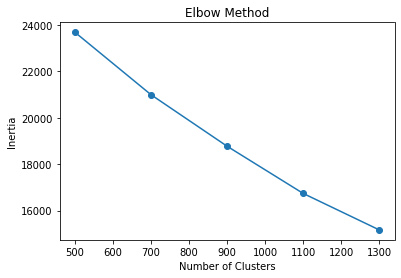

In [53]:
# Визуализация изменения инерции
plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [40]:
plt.savefig(r'/Users/mefeoss/Documents/DIPLOM/for_clust/elbow_1_50_kmeans_gsd_dev.png')

<Figure size 432x288 with 0 Axes>